In [2]:
import sys
sys.path.append('/Users/mrgr/Documents/GitHub/FiLeK/')
sys.path.append('/Users/mrgr/Documents/GitHub/KiDS_astronomaly/')
#import visualisation.tsne_plot
import numpy as np
import os
import glob
import importlib
import filek.utils as utils
import filek.gen_cutouts as gen_cutouts
from filek import cutclass
#import filek.models as models
import filek.settings as settings
from astropy.io import fits
import matplotlib.pyplot as plt
import filek.make_rgb as make_rgb
from filek.preprocessing import scaling_clipping
import pandas as pd

from astronomaly.anomaly_detection.human_loop_learning import NeighbourScore, ScoreConverter

%matplotlib inline

2023-05-08 09:43:48.576621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
if False:
    import shutil

    dir1 = '/Users/mrgr/lensto_download' # Replace with the path to the first directory
    dir2 = '/Users/mrgr/to_download'  # Replace with the path to the second directory

    for band in ['r_band', 'g_band', 'i_band']:
        band_dir1 = os.path.join(dir1, band)
        band_dir2 = os.path.join(dir2, band)
        for subdir in os.listdir(band_dir1):
            src_dir = os.path.join(band_dir1, subdir)
            dst_dir = os.path.join(band_dir2, subdir)
            if os.path.isdir(dst_dir):
                # If the destination directory already exists, add the files to it
                for filename in os.listdir(src_dir):
                    src_file = os.path.join(src_dir, filename)
                    dst_file = os.path.join(dst_dir, filename)
                    shutil.move(src_file, dst_file)
            else:
                # If the destination directory doesn't exist, move the entire source directory
                shutil.move(src_dir, dst_dir)


load labels

In [4]:
def drop_unnamed(df):
    """Drops any columns named 'Unnamed: n' with n any number."""
    return df.loc[:, ~df.columns.str.startswith('Unnamed:')]


df_list = pd.read_csv(os.path.join(settings.path_to_save_imgs, 'mock','df_list.csv')).dropna()
print('# Lenses {}, # not lenses {}, # tot {}'.format(len(df_list[df_list['LABEL']==1]),len(df_list[df_list['LABEL']==0]) , len(df_list)))
df_lens = pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock', 'I_have_lens_catalog.csv')).dropna()
print('# Lenses {}, # not lenses {}, # tot {}'.format(len(df_lens[df_lens['LABEL']==1]),len(df_lens[df_lens['LABEL']==0]) , len(df_lens)))

df_tot = pd.concat([df_list, df_lens], ignore_index=True).reset_index(drop=True).drop_duplicates()

df_tot = drop_unnamed(df_tot)
df_tot.rename(columns={"LABEL": "LABEL_TE"}, inplace=True)

df_tot = df_tot[df_tot['LABEL_TE'].isin([0, 1])].drop_duplicates(subset='KIDS_ID').reset_index(drop=True)
print('# Lenses {}, # not lenses {}, # tot {}'.format(len(df_tot[df_tot['LABEL_TE']==1]),len(df_tot[df_tot['LABEL_TE']==0]) , len(df_tot)))

#shuffle it
df_tot = df_tot.sample(frac=1).reset_index(drop=True)
df_tot.to_csv(os.path.join(settings.path_to_save_imgs,'mock','df_tot.csv'),  index=False)

#TODO: balance in test and train the amount of lenses
#train_df= pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock','train_df.csv'))
#test_df= pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock','test_df.csv'))


# Lenses 4, # not lenses 2408, # tot 2578
# Lenses 169, # not lenses 0, # tot 169
# Lenses 172, # not lenses 2342, # tot 2514


In [5]:
len(df_tot)

2514

In [6]:
if False:
    from sklearn.model_selection import train_test_split

    # Split your dataframe into training and test sets
    train_df, test_df = train_test_split(df_tot, test_size=0.2, random_state=42)
    train_df.to_csv(os.path.join(settings.path_to_save_imgs,'mock','train_df.csv'),  index=False)
    test_df.to_csv(os.path.join(settings.path_to_save_imgs,'mock','test_df.csv'), index=False)

In [7]:
if False:
    df_list_obj= pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock','test_df.csv')).drop_duplicates(subset='KIDS_ID').reset_index(drop=True)
    df_list_obj['FOLDER'] = str(os.path.join(settings.path_to_save_imgs,'mock'))
    for idx in range(len(df_list_obj)):
        try:
            utils.from_fits_to_array(df_list_obj.loc[idx, 'FOLDER'],
                                        df_list_obj.loc[idx,'KIDS_ID'] ,df_list_obj.loc[idx, 'KIDS_TILE'],  
                                        channels=['r', 'i','g'])
        except:
            print(idx)

In [8]:
def recall(ml_score, bin=1, column='LABEL_TE', sort_by='score'):

    #ml_score[column] = ml_score['Unnamed: 0'].map(df_tot.set_index('KIDS_ID')[column]).replace(1, 5)
    df_sorted = ml_score.sort_values(sort_by, ascending=False)
    num_elements = np.arange(1, len(df_sorted)+1, bin)
    recalls = []
    for i in num_elements:
        true_labels = df_sorted.iloc[:i][column]
        remaining_lablels = df_sorted.iloc[i:][column]
        TP = len(np.where(true_labels==5)[0])
        FN = len(np.where(remaining_lablels==5)[0])
        recall = TP / (TP+FN)
        
        recalls.append(recall)
    return num_elements, recalls


def tp_norm(ml_score, bin=1, column='LABEL_TE'):

    df_sorted = ml_score.sort_values('score', ascending=False)
    num_elements = np.arange(1, len(df_sorted)+1, bin)
    recalls = []
    for i in num_elements:
        true_labels = df_sorted.iloc[:i][column]
        TP = len(np.where(true_labels==5)[0])
        recall = TP / len(true_labels)
        recalls.append(recall)
    return num_elements, recalls

In [127]:
import errno
import re

def give_labels(df_tot, output_dir, num_to_label=200, max_labeled=400):
    try:
        features = pd.read_parquet(os.path.join(output_dir, 'FeatureScaler_output.parquet'))
    except:
        features = pd.read_parquet(os.path.join(output_dir, 'PCA_Decomposer_output.parquet'))

    filename = 'ScoreConverter_output.parquet'
   # path = os.path.join(output_dir,filename)

    #TODO add which one to load
    file_list = glob.glob( os.path.join(output_dir, filename.split('.')[0]+'*'))

    # Get the base filename and extension
    basename, ext = os.path.splitext(filename)

    if len(file_list)>1:# Define the naming pattern for the files you're looking for
        pattern = r"^ScoreConverter_output_(\d+)\.parquet$"

        # Get a list of all files in the directory that match the pattern
        files = [f for f in os.listdir(output_dir) if re.match(pattern, f)]

        # Sort the files by their suffixes
        files_sorted = sorted(files, key=lambda f: int(re.match(pattern, f).group(1)))

        # Return the last file (with the highest suffix)
        if files_sorted:
            filename = files_sorted[-1]
        else:
            filename = None
        print(f'loaded {filename}')


    elif os.path.exists(file_list[0]):
        #first time
        print(f'loaded {filename}')
    else:
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)

    anomalies = pd.read_parquet(os.path.join(output_dir,filename))

    if 'human_label' not in anomalies.columns:
        anomalies['human_label'] = [-1]*len(anomalies)

    anomalies= anomalies.sort_values('score', ascending=False)
    mask = anomalies['human_label'] == -1
    
    if len(anomalies.loc[~mask])>= max_labeled:
        return print('Max num of obj already labeled')
    rows_to_update = anomalies.loc[mask].iloc[:num_to_label].index
    try:
        df_tot = df_tot.set_index('KIDS_ID')
    except KeyError:
        pass
    #update both files, anomalies and ml_score
    anomalies.loc[rows_to_update, 'human_label'] = df_tot.loc[rows_to_update, 'LABEL_TE'].replace(1, 5)
    
    if os.path.exists(os.path.join(output_dir,'ml_scores.csv')) and len(mask)!=len(anomalies):
        #if it not the first time labeling 
        ml_df = pd.read_csv(os.path.join(output_dir,'ml_scores.csv'))
        try:
            ml_df = ml_df.set_index(['Unnamed: 0'])
        except KeyError:
            pass
    else:
        print('creating ml_scores.csv file ')
        #create the file
        IF_conv = pd.read_parquet(os.path.join(output_dir, 'ScoreConverter_output.parquet'))
        ml_df = IF_conv.assign(human_label=[-1]*len(IF_conv.score))

    if len(ml_df.loc[~mask])!= len(anomalies.loc[~mask]):
        if len(anomalies.loc[~mask])==200:
            #create the file, probably the loaded one is an old one
            IF_conv = pd.read_parquet(os.path.join(output_dir, 'ScoreConverter_output.parquet'))
            ml_df = IF_conv.assign(human_label=[-1]*len(IF_conv.score))
        else:
            raise ValueError('different amount of labels')
    ml_df.loc[rows_to_update, 'human_label'] = df_tot.loc[rows_to_update, 'LABEL_TE'].replace(1, 5)
    ml_df.to_csv(os.path.join(output_dir,'ml_scores.csv'))

    ns = NeighbourScore(alpha=0.1, force_rerun=True, output_dir = output_dir)
    features_with_labels = ns.combine_data_frames(features, anomalies)
    #return features_with_labels
    try:
        final_score = ns.run(features_with_labels.drop(['final_score'],axis=1))
    except KeyError:
        final_score = ns.run(features_with_labels)
    #except:
    #    return features_with_labels

    anomalies['final_score'] = final_score.trained_score
    num_lab = len(anomalies) - len(anomalies.loc[anomalies['human_label'] == -1])
    print(f'saved as ScoreConverter_{num_lab}_output.parquet')
    anomalies.to_parquet(os.path.join(output_dir, f'ScoreConverter_output_{num_lab}.parquet'))



In [86]:
def sorted_scoreconv(output_dir):
    pattern = r"^ScoreConverter_output_(\d+)\.parquet$"

    # Get a list of all files in the directory that match the pattern
    files = [f for f in os.listdir(output_dir) if re.match(pattern, f)]

    # Sort the files by their suffixes
    files_sorted = sorted(files, key=lambda f: int(re.match(pattern, f).group(1)))

    return files_sorted

def read_mlscore(output_dir):
    return pd.read_csv(os.path.join(output_dir, 'ml_scores.csv'))


In [87]:
def plot_recall_all_maxlabeled(list_subdir, num_labeled_=None):

    fig_dir = os.path.join(data_dir, 'figures')

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    img_prep_list = []


    #plot no active learning for comparison
    #the starting point is the same for all of them
    anomalies = pd.read_parquet(os.path.join(list_subdir[0],'ScoreConverter_output.parquet'))
    anomalies.loc[:, 'LABEL_TE'] = df_list_obj.loc[:, 'LABEL_TE'].replace(1, 5) 
    num_elements_tmp_sc, recalls_tmp_sc = recall(anomalies, sort_by='score')
    plt.plot(num_elements_tmp_sc, recalls_tmp_sc,  label='No active learning' )
  
    for subdir in list_subdir:
        img_prep = subdir.split('img_prep_')[1].split('_dim_')[0]
        img_prep_list.append(img_prep)

        if num_labeled_ is None:
           
            parq_filename = sorted_scoreconv(subdir)[-1]
            num_labeled = parq_filename.split('output_')[1].split('.parquet')[0] 
        else:
            #print([item for item in subdir if str(num_labeled_) in item])
            num_labeled  = str(num_labeled_)
            matches = [item for item in glob.glob(os.path.join(subdir,'*')) if num_labeled in item]
            if len(matches) > 0:
                parq_filename = matches[0]
            else:
                print(f"No files found with num_labeled = {num_labeled}")
                return

        anomalies = pd.read_parquet(os.path.join(subdir,parq_filename))
        anomalies.loc[:, 'LABEL_TE'] = df_list_obj.loc[:, 'LABEL_TE'].replace(1, 5) 
        
        label_fin = img_prep+f', {num_labeled} labeled'
        num_elements_tmp_fin, recalls_tmp_fin = recall(anomalies, sort_by='final_score')
        plt.plot(num_elements_tmp_fin, recalls_tmp_fin,label=label_fin) 

    plt.legend(loc='lower right')
    plt.title('Different preprocessing')
    plt.xlabel('Index in ranked list')
    plt.ylabel('Recall')

    plt.savefig(os.path.join(fig_dir,f'ALL_Recall_img_prep_{img_prep}_lab_{num_labeled}.png'))
    plt.show()



In [88]:
def plot_recall(subdir):
    
    fig_dir = os.path.join(subdir, 'figures')

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    parq_filename_list = []
    img_prep = subdir.split('img_prep_')[1].split('_dim_')[0]

    num_labeled_list = []
    for parq_filename in sorted_scoreconv(subdir):
        parq_filename_list.append(parq_filename)
        num_labeled = parq_filename.split('output_')[1].split('.parquet')[0] 
        num_labeled_list.append(num_labeled)
        anomalies = pd.read_parquet(os.path.join(subdir,parq_filename))
        anomalies.loc[:, 'LABEL_TE'] = df_list_obj.loc[:, 'LABEL_TE'].replace(1, 5) 
        #label_sc = f'{str(int(num_labeled)-200)} labeled'
        label_fin = f'{num_labeled} labeled'
        if int(num_labeled)==200:
            label_sc = 'No active learning' 
            num_elements_tmp_sc, recalls_tmp_sc = recall(anomalies, sort_by='score')
            plt.plot(num_elements_tmp_sc, recalls_tmp_sc,  label=label_sc)
        
        num_elements_tmp_fin, recalls_tmp_fin = recall(anomalies, sort_by='final_score')
        plt.plot(num_elements_tmp_fin, recalls_tmp_fin,label=label_fin) 

    plt.legend(loc='lower right')
    plt.title(f'img_prep : {img_prep}' )
    plt.xlabel('Index in ranked list')
    plt.ylabel('Recall')

    plt.savefig(os.path.join(fig_dir,f'Recall_img_prep_{img_prep}_lab_{"_".join(num_labeled_list)}.png'))
    plt.show()


In [135]:
# Set custom parameters using rcParams
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['legend.fontsize'] = 14


In [81]:
data_dir = os.path.join('/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/')
# Where output should be stored
output_dirs = sorted(glob.glob(os.path.join(data_dir, 'astronomaly_output','*')))
output_dirs = [item for item in output_dirs if os.path.isdir(item)]
df_list_obj= pd.read_csv(os.path.join(settings.path_to_save_imgs,'mock','df_tot.csv')).drop_duplicates(subset='KIDS_ID').reset_index(drop=True)[:-1]
df_list_obj = df_list_obj.set_index('KIDS_ID')
outdir_name =  [item.split('/')[-1] for item in output_dirs ]

len(df_list_obj[df_list_obj[ 'LABEL_TE'] ==1]), len(df_list_obj[df_list_obj[ 'LABEL_TE'] ==0])

(172, 2341)

In [128]:
features = pd.read_parquet(os.path.join(output_dirs[0], 'IforestAlgorithm_output.parquet'))
anomalies = pd.read_parquet(os.path.join(output_dirs[0],'pca_components.parquet'))

ns = NeighbourScore(alpha=0.1, force_rerun=True, output_dir =  output_dirs[0])
features_with_labels = ns.combine_data_frames(features, anomalies)

#final_score = ns.run(features_with_labels.drop(['final_score'],axis=1))

In [131]:
#outdir_name[0]
fin_score = give_labels(df_list_obj, output_dirs[0], num_to_label=200)

loaded ScoreConverter_output_400.parquet
Max num of obj already labeled


In [130]:
if True:
    for dir,dir_name in zip(output_dirs,outdir_name): 
        print(dir_name)
        give_labels(df_list_obj, dir, num_to_label=200)

NOSCALEkids_mock_img_prep_rband_scale_dim_red_pca_model_cnn_weights_zoobot
loaded ScoreConverter_output_200.parquet
creating ml_scores.csv file 
Running NeighbourScore ...
Done! Time taken: 10.104977130889893 s
saved as ScoreConverter_400_output.parquet
kids_mock_img_prep_grey_clipping_scale_dim_red_pca_model_cnn_weights_zoobot
loaded ScoreConverter_output_200.parquet
creating ml_scores.csv file 
/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/astronomaly_output/NOSCALEkids_mock_img_prep_rband_scale_dim_red_pca_model_cnn_weights_zoobot/astronomaly.log
Now switching to new log file:
/Users/mrgr/Documents/GitHub/KiDS_astronomaly/example_data/KiDS_cutouts/mock/astronomaly_output/kids_mock_img_prep_grey_clipping_scale_dim_red_pca_model_cnn_weights_zoobot/astronomaly.log
Running NeighbourScore ...
Done! Time taken: 5.333351135253906 s
saved as ScoreConverter_400_output.parquet
kids_mock_img_prep_grey_scaleclip_dim_red_pca_model_cnn_weights_zoobot
loaded ScoreCon

In [13]:
IF_conv = pd.read_parquet(os.path.join(output_dirs[0], 'ScoreConverter_output_200.parquet'))
ml_df = IF_conv.assign(human_label=[-1]*len(IF_conv.score)).sort_values('score', ascending=False)
mask = IF_conv['human_label'] == -1
rows_to_update = IF_conv.loc[mask].iloc[:100].index

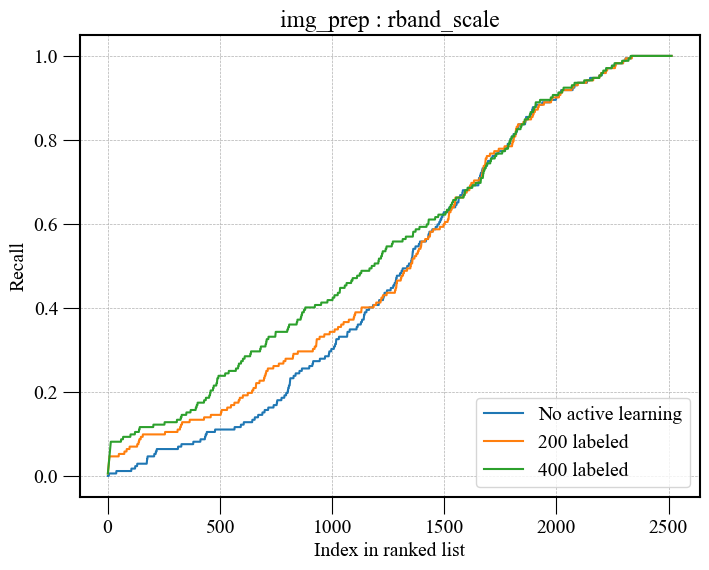

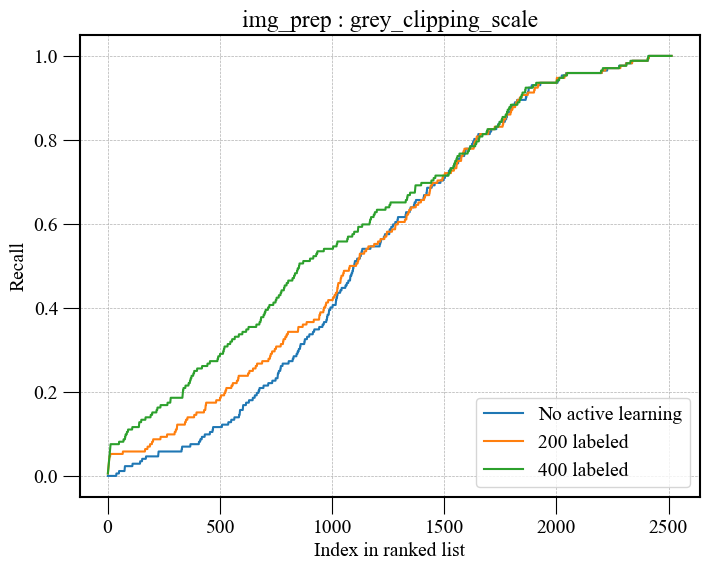

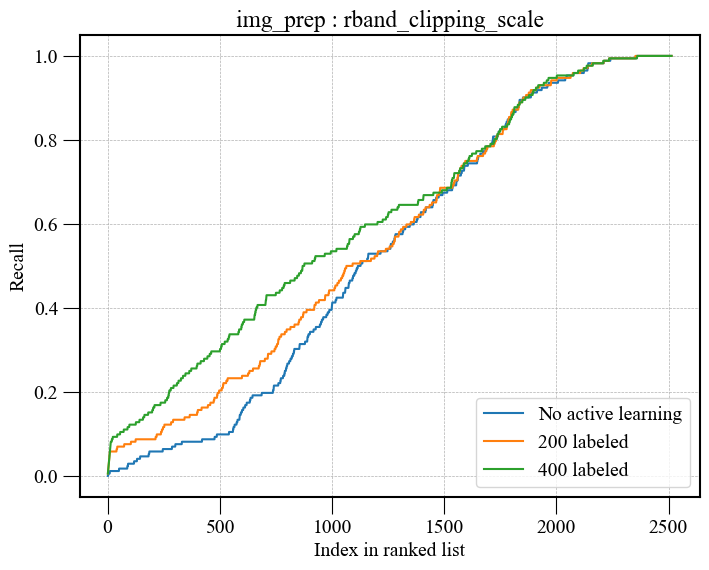

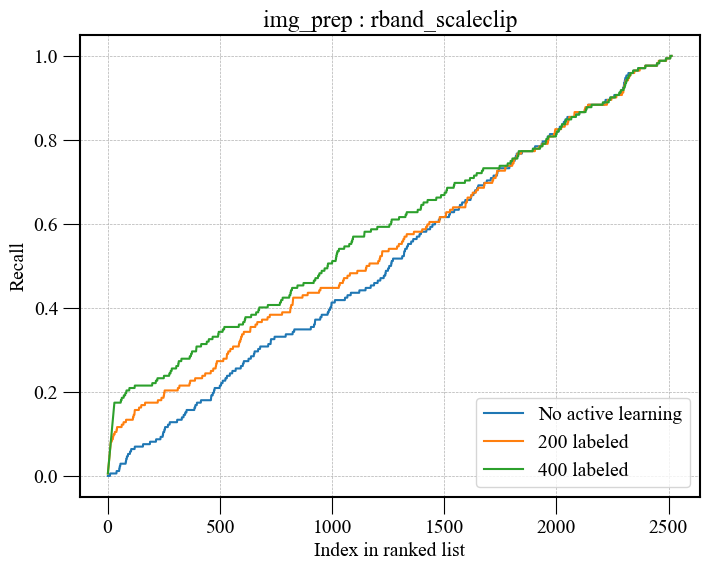

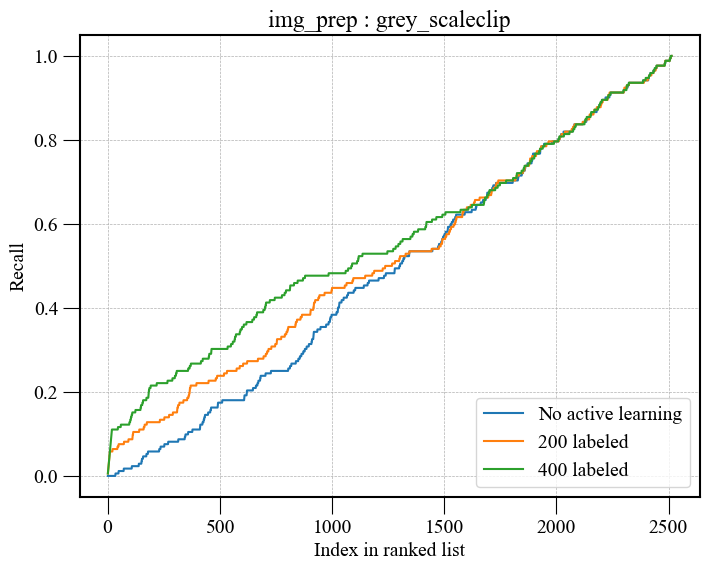

In [62]:
output_dirs = glob.glob(os.path.join(data_dir, 'astronomaly_output','*'))
#check that i have only folders
output_dirs = [item for item in output_dirs if os.path.isdir(item)]
for subdir in output_dirs:
    plot_recall(subdir)

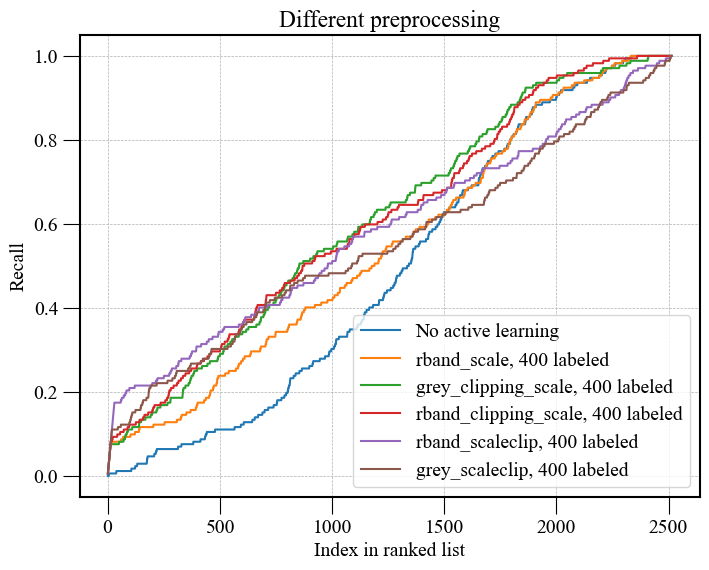

In [61]:
plot_recall_all_maxlabeled(output_dirs,num_labeled_=400 )

In [72]:
def get_SNR(img):
    # Compute the mean and standard deviation of the image
    mean = np.mean(img)
    std = np.std(img)

    # Calculate the SNR
    snr = 20 * np.log10(mean / std)
    return snr
    

In [73]:
def change_specialcharacters(string):
    return string.replace('KIDS', 'KiDS_DR4.0').replace('.', 'p').replace('-', 'm').rstrip(' ')
def from_fits_to_array(folder_path, img_ID, tile_ID, channels=['r','i','g'] ):

    img=[]

    tile_ID = change_specialcharacters(tile_ID)
    if len(channels)==1:
        channels=[channels]
    for f in channels:
        try:
            hdu = fits.getdata(os.path.join(folder_path,f+'_band','tile_'+tile_ID, img_ID+'.fits' ),
                                memmap=True)
        except FileNotFoundError:
            try:
                hdu = fits.getdata(os.path.join(folder_path,f+'_band',tile_ID, img_ID+'.fits') ,
                                memmap=True)
            except:
                print(tile_ID,img_ID)
                continue
                
        img.append(hdu)
    #wcs = WCS(hdu.header)
        #print(img)

    return np.array(img)

import filek.settings as settings
data_dir = os.path.join(settings.path_to_save_imgs,'mock')
df_list_obj['FOLDER'] = data_dir
snr = []
for i in range(len(df_list_obj)):
    img = from_fits_to_array(df_list_obj.loc[df_list_obj.index[i],'FOLDER'] , df_list_obj.index[i], 
                             df_list_obj.loc[df_list_obj.index[i],'KIDS_TILE'], channels=['r','i','g'] )
    
    img = np.transpose(img, (1,2,0)) 
    snr.append(get_SNR(img))

/var/folders/t8/mrbk3_1j5s13vdp0sngjx3nw0000gn/T/ipykernel_33142/3342059969.py:7: RuntimeWarning: invalid value encountered in log10
  snr = 20 * np.log10(mean / std)
2023-05-08 14:35:27,530 - WARNING - File may have been truncated: actual file length (43684) is smaller than the expected size (46080)


In [188]:
def create_2d_rgb_image(rgb_image):
    # Compute the average value across color channels
    average_color = np.mean(rgb_image, axis=2)
    return average_color


In [142]:
from astronomaly.preprocessing import image_preprocessing

/var/folders/t8/mrbk3_1j5s13vdp0sngjx3nw0000gn/T/ipykernel_33142/2517502856.py:4: RuntimeWarning: invalid value encountered in log10
  img_log = np.log10(img)


ValueError: num must be an integer with 1 <= num <= 9, not 10

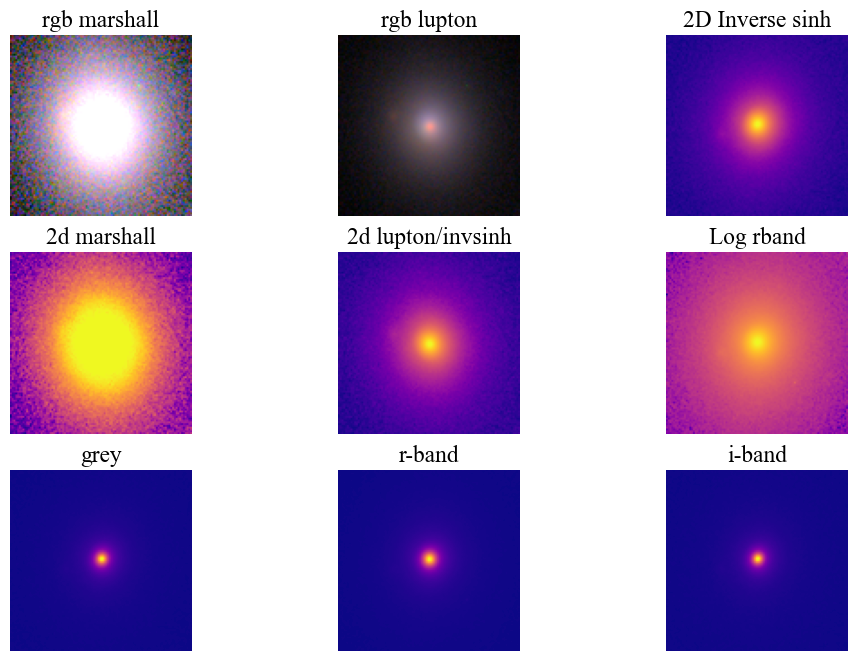

In [250]:
import matplotlib.pyplot as plt

img_sinh =image_preprocessing.image_transform_inverse_sinh(img)
img_log = np.log10(img)
img_log_scaled = np.log(scaling_clipping(img[:, :, 0]))

img_rgb = make_rgb.make_rgb_one_image(img_array=img, type_plot='marshall')
img_rgb2 = make_rgb.make_rgb_one_image(img_array=img, type_plot='lupton')
img_rgbsinh = create_2d_rgb_image(image_preprocessing.image_transform_inverse_sinh(img))
img_grey = image_preprocessing.image_transform_greyscale(img)
rgb_2dim1 = create_2d_rgb_image(img_rgb)
rgb_2dim2 = create_2d_rgb_image(img_rgb2)

# Calculate the number of subplots
num_subplots = 8

# Determine the number of rows and columns for the subplot grid
num_rows = (num_subplots + 2) // 3  # 2 is added to round up the division
num_cols = 3

cmap= 'plasma' #viridis
# Create the subplots individually
fig = plt.figure(figsize=(12, 8))

i = 1
# Plot the first subplot
ax1 = plt.subplot(num_rows, num_cols, i)
ax1.imshow(img_rgb)
ax1.set_title('rgb marshall')
ax1.axis('off')

i += 1
# Plot the second subplot
ax2 = plt.subplot(num_rows, num_cols, i)
ax2.imshow(img_rgb2)
ax2.set_title('rgb lupton')
ax2.axis('off')

i += 1
# Plot the fifth subplot
ax5 = plt.subplot(num_rows, num_cols, i)
ax5.imshow(img_rgbsinh, cmap=cmap)
ax5.set_title('2D Inverse sinh')
ax5.axis('off')

i += 1
# Plot the third subplot
ax3 = plt.subplot(num_rows, num_cols, i)
ax3.imshow(rgb_2dim1, cmap=cmap)
ax3.set_title('2d marshall')
ax3.axis('off')

i += 1
# Plot the fourth subplot
ax4 = plt.subplot(num_rows, num_cols, i)
ax4.imshow(rgb_2dim2, cmap=cmap)
ax4.set_title('2d lupton/invsinh')
ax4.axis('off')

i += 1
# Plot the sixth subplot
ax6 = plt.subplot(num_rows, num_cols, i)
ax6.imshow(img_log[:,:,0], cmap=cmap)
ax6.set_title('Log rband')
ax6.axis('off')

i += 1
# Plot the seventh subplot
ax7 = plt.subplot(num_rows, num_cols, i)
ax7.imshow(img[:,:,0], cmap=cmap)
ax7.set_title('r-band')
ax7.axis('off')

i += 1
# Plot the seventh subplot
ax7 = plt.subplot(num_rows, num_cols, i)
ax7.imshow(img[:,:,1], cmap=cmap)
ax7.set_title('i-band')
ax7.axis('off')

i += 1
# Plot the seventh subplot
ax7 = plt.subplot(num_rows, num_cols, i)
ax7.imshow(img[:,:,2], cmap=cmap)
ax7.set_title('g-band')
ax7.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [243]:
import importlib
importlib.reload(make_rgb)

<module 'filek.make_rgb' from '/Users/mrgr/Documents/GitHub/FiLeK/filek/make_rgb.py'>